# Machine Learning Paradigms - Rental Bike Predictions



*This report demonstrates three approaches to a highly non-linear prediction task. Guassian process regression, tree regression and random forests are implemented and compared.*

## 1 | Introduction 
---
This report describes a solution to the **University of Bristol - Machine Learning Paradigms Kaggle competition**, which requires prediction of bicycle availability at rental stations across Valencia. The competition consists of three phases:

* **Phase 1**: Given one month of historical data from 75 rental stations[201:275], predict 3 months of bicycle availability for each station by :
    * (a) generating a learning model for each individual station, trained on it's own data
    * (b) generating a combined learning model which trains on all station data as a single dataset. <br><br>

* **Phase 2**: Predict bicycle availability by applying pre-trained linear models trained on 200 different stations [1:200] from 1 years worth of data, where six models for each station have been provided, totalling 1200 linear models. Determining the best blend of these models to produce optimim results is determined experimentally. <br><br>

* **Phase 3**: Attempt improved prediction performance by combining both the learning model from **Phase 1** and the linear models from **Phase 2**. <br><br>



#### Data overview
The graphic below shows how the data and pre-trained linear models are split for phases 1 & 2 along with the Kaggle test, what stations they are related to and over what time peried the data is collected or models are trained.

![Getting Started](./data/Images/data_overview4.png)

#### Project Flowchart

The flowchart below describes the project breakdown from phase 1-3. 

![Getting Started](./data/Images/flowchart3.png)

## 2 | Methodology
----

### 2.1 | Data Exploration

The first step in the process of generating predicitive models is to properly understand the dataset. The dataset provided consists of various features, including information regarding the individual **station** and the **time** and **weather**, and task-related features to do with the time-history of number of bikes at each station. All features are listed in Table §§

#### Load data ####


In [28]:
# LOAD MODULES & DATASET
%load_ext autoreload
%autoreload 2

from multiprocessing.sharedctypes import Value
import numpy as np
import random
import os
import pandas as pd
import plotly.express as px
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.impute import SimpleImputer
import pickle

# User-defined
from utilities import data_saver
from fe_utilities import interpolation, weekday_handler, darkness, pca_app, station_proximity

# Set load/save path 
dw_directory = "./data" # Set data directory

stations = np.linspace(201, 275, 75)
dataset = pd.DataFrame()

for i in stations:
    filepath = os.path.join(dw_directory, 'Train', 'Train', 'station_' + str(int(i)) + '_deploy.csv')

    with open(filepath, 'r') as f:
        data_v = pd.read_csv(f)
         
        if len(dataset) == 0:
            dataset = data_v
        else:
            dataset = dataset.append(data_v)

dataset.head(10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,station,latitude,longitude,numDocks,timestamp,year,month,day,hour,weekday,...,temperature.C,relHumidity.HR,airPressure.mb,precipitation.l.m2,bikes_3h_ago,full_profile_3h_diff_bikes,full_profile_bikes,short_profile_3h_diff_bikes,short_profile_bikes,bikes
0,201,39.478178,-0.383541,27,1.412114e+09,2014,10,1,0,Wednesday,...,21.3,85.0,855.3,0.0,NaN,NaN,NaN,NaN,NaN,1.0
1,201,39.478178,-0.383541,27,1.412118e+09,2014,10,1,1,Wednesday,...,21.1,86.0,1000.6,0.0,NaN,NaN,NaN,NaN,NaN,0.0
2,201,39.478178,-0.383541,27,1.412122e+09,2014,10,1,2,Wednesday,...,20.9,86.0,880.6,0.0,NaN,NaN,NaN,NaN,NaN,0.0
3,201,39.478178,-0.383541,27,1.412125e+09,2014,10,1,3,Wednesday,...,20.4,88.0,859.8,0.0,1.0,NaN,NaN,NaN,NaN,0.0
4,201,39.478178,-0.383541,27,1.412129e+09,2014,10,1,4,Wednesday,...,20.3,87.0,898.1,0.0,0.0,NaN,NaN,NaN,NaN,0.0
5,201,39.478178,-0.383541,27,1.412132e+09,2014,10,1,5,Wednesday,...,20.1,88.0,910.6,0.0,0.0,NaN,NaN,NaN,NaN,0.0
6,201,39.478178,-0.383541,27,1.412136e+09,2014,10,1,6,Wednesday,...,19.6,89.0,908.1,0.0,0.0,NaN,NaN,NaN,NaN,0.0
7,201,39.478178,-0.383541,27,1.412140e+09,2014,10,1,7,Wednesday,...,19.7,89.0,987.8,0.0,0.0,NaN,NaN,NaN,NaN,0.0
8,201,39.478178,-0.383541,27,1.412143e+09,2014,10,1,8,Wednesday,...,19.8,88.0,971.3,0.0,0.0,NaN,NaN,NaN,NaN,8.0
9,201,39.478178,-0.383541,27,1.412147e+09,2014,10,1,9,Wednesday,...,20.1,87.0,983.1,0.0,0.0,NaN,NaN,NaN,NaN,6.0


#### Feature overview ####

| Category | Features | Description |
| --- | -----------: | :--------- |
| Station | Station ID <br> Latitude <br> Longitude <br> Number of Docks | Non-correlated station ID number <br>  - <br> - <br> Max amount of bikes per station (varies between stations) |
| Time | Timestamp <br> Year <br> Month <br> Day <br> Hour <br> Weekday <br> Week-hour <br> Holiday | Seconds <br> - <br> - <br> - <br> - <br> Mon-Sun <br> 1:168 <br> 1 or 0 |
| Weather | Max Wind Speed <br> Mean Wind Speed <br> Wind Direction <br> Temperature <br> Relative Humidity <br> Air Pressure <br> Precipitation | $ms^{-1}$ <br> $ms^{-1}$ <br> $\text{\textdegree}$ <br> $C\text{\textdegree}$ <br> $\text{\%}$ <br> $mBar$ <br> $L/m^2$
| Task-Specific | Bikes 3h Ago | Number of bikes at a given station 3 hrs prior to the current timestamp |
| Profile | Full profile <br> Full profile 3 hours ago <br> Short Profile <br> Short Profile three hours ago | Average bike numbers for the current week-hour during all previous weeks <br> As above for 3 hrs prior <br> Average bike numbers for the current week-hour over the last four weeks <br> As above for 3 hrs prior |
|Target | Bikes | Number of bikes at the station i.e. the variable we are trying to predict





#### Plot station map

We can plot latitude and longitude of each station on a map of Valencia, with markers representing the station capacity (grey) and the average number of bikes per station (red). This view provides a perspective of station business, as we can see very large capacity stations that are never full. It can be seen that density of stations varies across location and suggests a higher number of bikes in the South East, perhaps this is more of a leisure destination and doesn't befall quite as much commuter traffic.


In [29]:
import folium

stations_lat = pd.unique(dataset['latitude'])
stations_long = pd.unique(dataset['longitude'])
stations_no = pd.DataFrame(pd.unique(dataset['station']), columns=['station'])
station_docks = dataset['numDocks'].values

stations = np.stack((stations_lat, stations_long), axis=1)
stations = pd.DataFrame(stations, columns = ['latitude', 'longitude'])

locations = stations[['latitude', 'longitude']]
locationlist = locations.values.tolist()

n_bikes = bikes['bikes'].values.reshape(-1,1)
imp_mean.fit(n_bikes)
n_bikes = imp_mean.transform(n_bikes)

stat_ns = dataset['station'].values

mean_bikes = []
numDocks = []

for i in range(0,len(stations_no.values)):
    
    stat_n = stations_no.values[i]
    t_f = stat_ns == stat_n

    index = [i for i, x in enumerate(t_f) if x]
    index = np.reshape(index,(-1,1))
    mean_bikes.append(sum(n_bikes[index])/len(n_bikes[index]))
    numDocks.append(station_docks[index])



f = folium.Figure(width=700, height=700)
map = folium.Map(location = [39.4502730411,-0.333362], tiles='OpenStreetMap' , zoom_start = 12)

for point in range(0, len(stations)):

    folium.Circle(
    locationlist[point],
    color='black',
    radius=float(10*numDocks[point][0][0]),
    fill=True,
    opacity=0.8,
    fill_opacity=0.2,
    # tooltip='Station {}: {}'.format(stations_no['station'][point],round(mean_bikes[point][0][0]))
    ).add_to(map)
    
    folium.Circle(
    locationlist[point],
    color='red',
    radius=10*mean_bikes[point][0][0],
    fill=True,
    opacity=0.1,
    fill_opacity=0.3,
    tooltip='Station {}| Docks: {} | Average Bikes {}'.format(stations_no['station'][point],numDocks[point][0][0],round(mean_bikes[point][0][0]))
    ).add_to(map)    

f.add_child(map)
# f.savefig('data/USER/Figures/folium_valencia.jpeg',dpi = 300)
f

Understanding the impact of each feature on variance of bikes can be achieved statistically, but first we will simply observe them, to see if any obvious inferences can be made. 

We will look at the variation of number of bikes with respect to each feature, and also perform a single-component partial least squares (PLS) regression analysis. This yields a metric to help us better understand the correlation between each feature and the number of bikes. 

/Users/philippatton/Documents/Data science/MB_2021/MB21env/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:93: RuntimeWarning: invalid value encountered in true_divide
  y_weights = np.dot(Y.T, x_score) / np.dot(x_score.T, x_score)
/Users/philippatton/Documents/Data science/MB_2021/MB21env/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:325: RuntimeWarning: invalid value encountered in true_divide
  x_loadings = np.dot(x_scores, Xk) / np.dot(x_scores, x_scores)
/Users/philippatton/Documents/Data science/MB_2021/MB21env/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:334: RuntimeWarning: invalid value encountered in true_divide
  y_loadings = np.dot(x_scores, Yk) / np.dot(x_scores, x_scores)
/Users/philippatton/Documents/Data science/MB_2021/MB21env/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:93: RuntimeWarning: invalid value encountered in true_divide
  y_weights = np.dot(Y.T, x_score) / np.dot(x_score.T, x_score)
/Use

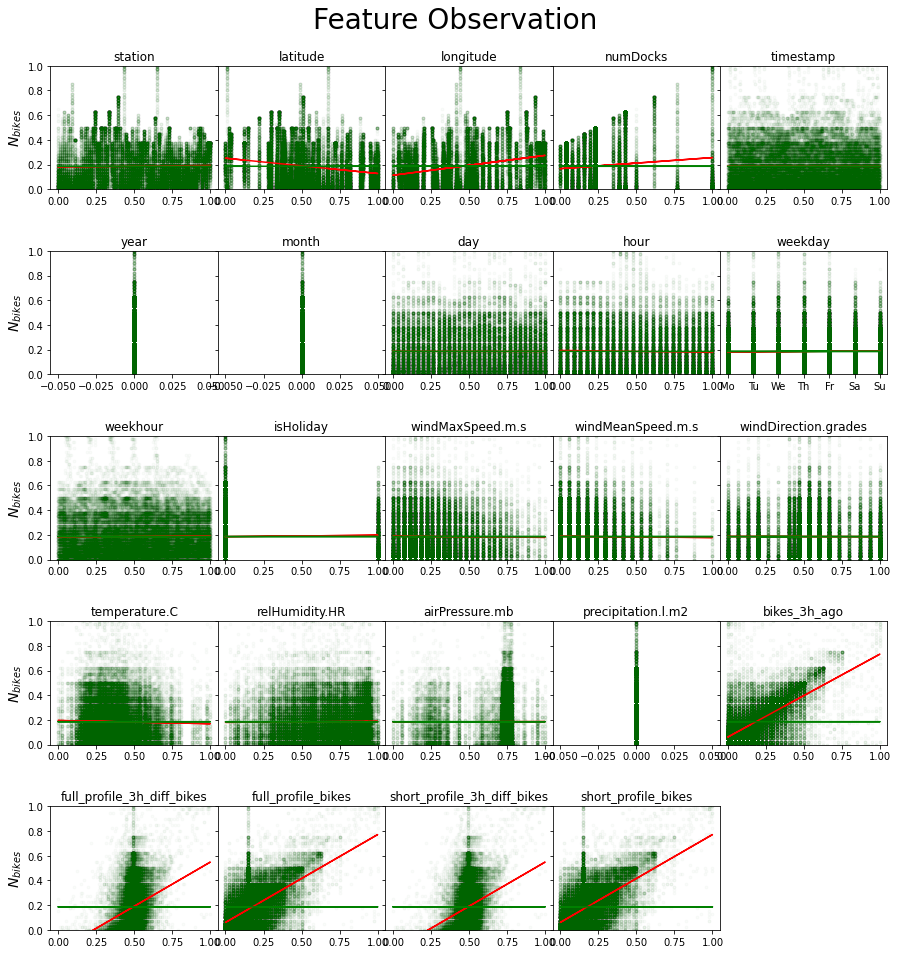

In [30]:
bikes = pd.DataFrame(dataset['bikes'].copy())
dataset = dataset.drop(['bikes'],axis=1)

pls = PLSRegression(n_components=1,scale = False)
pls_data = {'Feature':[],'Score':[]}

imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
columns = dataset.columns.values
scaler = MinMaxScaler()
n = len(columns)
n_sq = np.sqrt(n)
n_plt = int(np.ceil(n_sq))



fig, axs = plt.subplots(n_plt,n_plt, sharey=True,figsize=(15,15))
fig.suptitle('Feature Observation',fontsize = 28)

for i in range(0,n_plt**2):

    row = int(np.floor(i/n_plt))
    col = int(i%n_sq)

    if (n_plt*row + col) > n-1:
        axs[row,col].set_visible(False)
        
        continue

    x = dataset[columns[i]].values
    y = bikes['bikes']

    dotw = False
    weekDays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    try:
        if 'day' in str(x[0]):
            x = [weekDays.index(n) for n in x]
            dotw = True
    except:
            pass
    
    x = [float(i) for i in x]
    x = np.reshape(np.array(x),(-1, 1))
    y = [float(i) for i in y]
    y = np.reshape(np.array(y),(-1, 1))

    scaler.fit(x)
    x = scaler.transform(x)
    imp_mean.fit(x)
    x = imp_mean.transform(x)

    scaler.fit(y)
    y = scaler.transform(y)
    imp_mean.fit(y)
    y = imp_mean.transform(y)

    # x = np.float32(x)
    # y = np.float32(y)
    y_mean = np.ones(len(y))*np.mean(y)

    try:
        pls.fit(x, y)
        corr_score = pls.score(x,y)
        # x = pls.transform(x)
        y_p = pls.predict(x)

        pls_data['Feature'].append(columns[i])
        pls_data['Score'].append(corr_score)

        axs[row,col].scatter(x,y,marker='.',c='darkgreen',alpha = 0.02) 
        axs[row,col].plot(x,y_p,c='r')
    except:
        axs[row,col].scatter(x,y,marker='.',c='darkgreen',alpha = 0.02) 

    axs[row,col].plot(x,y_mean,c='g') 
    axs[row,col].set_ylim([0,1])
    # axs[row,col].set_xlim([min(x),max(x)])
    axs[row,col].set_title(columns[i])

    if dotw == True:
        t_list = np.linspace(min(x),max(x),7)
        tick_list = [item for sublist in t_list for item in sublist]
        
        axs[row,col].set_xticks(tick_list, [d[0:2] for d in weekDays])

    if col == 0:
        axs[row,col].set_ylabel(r'$N_{bikes}$',fontsize =14)

plt.subplots_adjust(wspace=0,hspace = 0.5,top=0.925)
#plt.savefig('data/USER/Figures/Feature_Observations.jpeg',dpi = 300,bbox_inches='tight')


The figure above shows a **normalised** plot of each feature (x) against number of bikes (y). A green line shows the mean number of bikes, and a red line indicates our "predictions" from the PLS analysis, which in this context is our line of best fit. The coefficient of determination ($R^2$) is calculated for each variable and is presented in Figure §§.

Looking at the feature plots, it is clear that **month**, **year** and **precipitation** will have zero effect on the results as they do not vary, and so they are ommited (however, if the models in Phase Two considered the month and year then this might not be the case). Here are some other guesses which are made from observing the data:

1. A small number of stations have a much higher capacity of bikes than the rest
2. On holidays, and at weekends, these high capacity stations are never full
3. There is a concentration of bicycles in the South-East of Valencia
3. Both lower temperature and higher humidity indicate higher numbers of bikes
4. The number of bikes 3 hours ago is the feature with the most influence
5. For the profile features, the full and short profiles are identical


### 2.2 Data cleaning

#### Imputing NaN values
Sklearn's SimpleImpputer was chosen deal with NaN values. The figure below shows the spread of NaN values where the majority of NaNs are from the features ['bikes_3h_ago', 'full_profile_3h_diff_bikes','full_profile_bikes', 'short_profile_3h_diff_bikes','short_profile_bikes']. This is because for each station these features are based on the number of bikes present 3hrs before which is not available for the first three hours of each day. To deal with these, the SimpleImputer replaces NaNs with the median value given for each station. Other techniques could be used for dealing with NaNs but were not investigated at this time. 

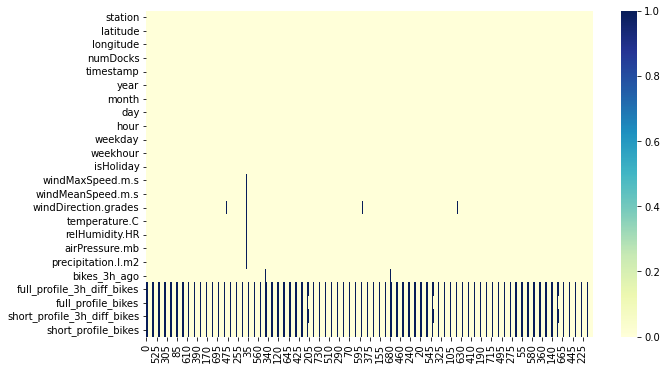

In [31]:
plt.figure(figsize=(10,6))
sns.heatmap(dataset.isna().transpose(), cmap="YlGnBu")

dataseta = dataset.drop(['weekday'], axis=1)

imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
imp_mean.fit(dataseta)   

dataseta = pd.DataFrame(imp_mean.transform(dataseta), columns=dataseta.columns)

dataseta['weekday'] = dataset['weekday'].reindex().tolist()

dataseta = dataseta.dropna()

#### Onehotencoding categorical data

OneHotEncoding using sklearn was the method chosen to deal with categorical data which for this dataset is only the feature 'weekday'. Using the code below the weekday column is transformed into seven binary columns representing each day of the week.

In [32]:
enc = OneHotEncoder(handle_unknown='ignore')
cols_d = np.array(dataseta['weekday']).reshape(-1,1)
enc.fit(cols_d)
cols = enc.categories_[0].tolist()
cols_d = pd.DataFrame(enc.transform(cols_d).toarray(), columns=cols)

datasetb = dataseta.drop(['weekday'], axis=1)

datasetb =  pd.concat([datasetb, cols_d], axis=1).reindex(datasetb.index)

### 2.3 Feature Engineering

#### Supervised features added
After exploring the data, some supervised features were added to discover whether greater performance could be found by understanding the problem further. 

#### Is it dark?
The dataset contains time and useful features like whether it is a national holiday, but it does not distiguish datapoints during sunlight hours which may be a driving feature for bike users. The library 'astral' was used to determine sunrise and sunset time for each day and impute a binary column for darkness.

In [33]:
# is it dark?

from astral import LocationInfo
from astral.sun import sun

city = LocationInfo(39.4502730411, -0.3333629598)

dk = pd.to_datetime(dataseta['timestamp'], unit='s')
darkness = []
for i in dk:
    s = sun(city.observer, date=i)
    srise = s['sunrise'].replace(tzinfo=None)
    sset = s['sunset'].replace(tzinfo=None)
    if i < sset and i > srise:
        d = 0
    else:
        d = 1
    if len(darkness) == 0:
        darkness = [d]
    else:
        darkness.append(d)

datasetb['darkness'] = darkness

#### Distance to nearest station
As shown in the map plot, density of rental stations vary across the city and so having a metric for this feature may be important. The code below was used to add a column which states distance between each rental station and it's closest neighbour. This metric does not fully capture station density but is a simple way of understanding if a station is isolated or not. 

In [34]:
## distance to another station
import geopy.distance
from scipy import spatial

stations_lat = pd.unique(datasetb['latitude'])
stations_long = pd.unique(datasetb['longitude'])

stations = np.stack((stations_lat, stations_long), axis=1)

no_s = np.linspace(0,74, 75)

near = []
for si1 in no_s:
    distance = []
    for si2 in no_s:
        if si1 == si2:
            continue
        dist = geopy.distance.geodesic(stations[int(si1),:], stations[int(si2),:]).km
        if len(distance) ==0:
            distance = [dist]
        else:
            distance.append(dist)
    nearest = min(distance)
    if len(near) == 0:
        near = [nearest]
    else:
        near.append(nearest)


#%%
def label_dist (row):
    x = near[int(row['station'])-int(201)]
    return x

datasetb['distance'] = datasetb.apply (lambda row: label_dist(row), axis=1)

#### Feature Pearson score

Pearson's coefficient was used to understand linear correlation of features against the target 'Bikes'. The plot below shows that the highest correlation comes from the features based on the numberof bikes 3hrs ago which is expected. For the added supervised features, 'darkness' shows very low correlation of 0.025 and 'distance' to nearest station gives 0.169 which is also low but worth investigating.

In [1]:
import scipy

bikes = pd.DataFrame(datasetb['bikes'].copy())
dataset_score = datasetb.drop(['bikes'],axis=1)
pls = PLSRegression(n_components=1,scale = False)
pls_data = {'Feature':[],'Score':[]}
columns = dataset_score.columns.values
n = len(columns)

for i in np.linspace(0,n-1,n):
    row = int(np.floor(i/n_plt))
    col = int(i%n_sq)

    x = np.squeeze(np.asarray(dataset_score[columns[int(i)]]))    
    y = np.squeeze(np.asarray(bikes['bikes']))

    corr_score =  scipy.stats.pearsonr(x, y)[0]
    pls_data['Feature'].append(columns[int(i)])
    pls_data['Score'].append(corr_score)
    
df = pd.DataFrame({"Scores": pls_data['Score']},
                  index=pls_data['Feature'])
plt.figure(figsize = (5,10))
ax = sns.heatmap(df, annot=True, fmt="g", cmap='viridis',yticklabels=pls_data['Feature'])


NameError: name 'pd' is not defined

#### Feature sets

For this investigation, datasets were defined with different feature sets and a control group **A** containing all features. As the models were trained both on individual stations, and on an entire models, the groups below have an 'individual' and 'combined' version which only vary by the removal of metadata. The groups have bene chosen based on their pearson scores with the aim of reducing computation time and understanding the effect of reducing dimensions

The sub-groups are defined below with an 80:20 randomised train-validation split chosen for dividing data

| Group | Model       |   Features |
| :---: | ----------- | :--------- |
| $A$ <br> (control)    | Individual/ <br> Combined | 'station', 'latitude', 'longitude', 'numDocks', 'timestamp','year', 'month', 'day', 'hour', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'weekhour', 'isHoliday', 'windMaxSpeed.m.s', 'windMeanSpeed.m.s', 'windDirection.grades', 'temperature.C', 'relHumidity.HR', 'airPressure.mb', 'precipitation.l.m2', 'bikes_3h_ago', 'full_profile_3h_diff_bikes','full_profile_bikes', 'short_profile_3h_diff_bikes','short_profile_bikes'|
| $B_i$| Individual |'timestamp', 'day', 'hour', 'Monday','Tuesday','Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday', 'weekhour', 'isHoliday', 'windMaxSpeed.m.s', 'windMeanSpeed.m.s', 'windDirection.grades','temperature.C', 'relHumidity.HR','airPressure.mb', 'bikes_3h_ago', 'full_profile_3h_diff_bikes', 'full_profile_bikes'|
| $B_c$| Combined| As above, plus 'station', 'latitude', 'longitude', 'numDocks'|
| $C_i$| Individual | 'bikes_3h_ago', 'full_profile_3h_diff_bikes','full_profile_bikes'|
| $C_c$| Combined| As above, plus 'latitude', 'longitude', 'numDocks'|
| $D_i$| Individual | 'weekhour', 'isDark', 'isWeekend', 'isHoliday', 'bikes_3h_ago', 'full_profile_3h_diff_bikes', 'full_profile_bikes'|
| $D_c$| Combined| As above, plus 'latitude', 'longitude', 'numDocks'|


### 2.4 Phase 1 algorithm selection

Three model types were investigated based on sutability to the problem:
* Bayesian Regression
* Tree Regression
* Tree Ensembles

The aim of this approach is to understand how these algorithms can handle this type of data, and so any conclusions drawn are constrained to similar contexts.

#### Bayesian Regression
The chosen approach to the regression problem is Gaussian process regression, as it allows experimenting with different covariance kernels and draw inferences about the results with respect to the smoothness of the predicted function. The Matern class of covariance kernels will be applied, with the covariance matrix is defined as:
<br><center>
$k_{x_i,x_j} = \dfrac{1}{\Gamma(\nu)2^{\nu-1}} \left(\dfrac{\sqrt{2\nu}}{l} d(x_i,x_j) \right)^\nu K_\nu \left(\dfrac{\sqrt{2\nu}}{l} d(x_i,x_j)  \right)$
</center>

where $ d(\cdot,\cdot)$ is euclidian distance, $K_\nu(\cdot)$ is a modified Bessel function, and $\Gamma(\cdot)$ is the gamma function. We modify the parameter $\nu$ to reflect our expectation of the smoothness of the data. As $\nu$ increases, so does our expectation that the data is smooth.

#### Tree Regression
A tree-based regression method to predict continuous data. For each feature, the regression tree will iteratively split the data into clusters, and measure the squared residual error from assigning one output variable to each cluster. By finding the minimum squared residual error per split, and then recursively performing this step, a tree can be developed which segments the data (hopefully by our categorical features) then learns a function for each cluster. Min samples per leaf and maximum depth were modified to understand whether the model is overfitting on the validation set.

#### Tree Ensemble Methods
One problem with classic tree regression is accuracy - specifically, tree regressor commonly fit well to traiing data, but struggle to apply classifications to new samples; they are inflexible. One solution is to use a random forest ensemble method. This involves bootsrap aggregating, or bagging, whereby  randomly selecting subsets of variables in order to create a large variety of decision trees. Although each of these trees may produce poor predictions individually, by aggregating the results of each tree, it becomes possible to make a decision on the final output based on the most popular output term. Like in the tree method, we can modify minimum samples per leaf and maximum depth to investigate the effects of tree pruning.

### 2.5 Phase 1 Test Plan
The following presents a summary of the methods under test and associated parameter variation.

| Model |   Parameters | Parameter (Starting) Values |
| :---: | ----------- | :--------- | 
| Guassian Process Regression   | $\nu$     |  0.5; 1.5; 2.5 |
| Tree Regression |     Min. Samples Per Leaf <br> Maximum Depth| 1; 3; 5 <br> Max; Max_D/1.1 ; Max_D/1.3 Max_D/2|
| Random Forest Regression |     Min. Samples Per Leaf <br> Maximum Depth| 1; 3; 5 <br> Max; Max_D/1.1 ; Max_D/1.3 Max_D/2|

All models used are from the SciKit Learn family and are tuned in line with the steps outlined in the documentation (https://scikit-learn.org/stable/supervised_learning.html#supervised-learning). The parameter values are referred to as **starting** values as we expect to stray from this set in the fine tuning of these models; these ranges indicate our initial search space.

### 2.6 Phase 2 linear model testing
Six types of linear models are provided pre-trained for Phase 2, with individual weights for stations [1:200]. Assessment of these models is achieved by averaging the weights of each type of model and then performing inference on a test set. Initially the models are campared against eachother, and then performance of blended models is assessed. 

|Model Type | Equation| 
| -------|------------|
| full temp| $Bikes = (M_{Bikes-3h-ago}*X_{Bikes-3h-ago}) + (M_{full-profile-bikes}*X_{full-profile-bikes}) + (M_{full-profile-3h-diff-bikes}*X_{full-profile-3h-diff-bikes}) + (M_{temperature.C}*X_{temperature.C}) + Intercept$| 
|||
| full | $Bikes = (M_{Bikes-3h-ago}*X_{Bikes-3h-ago}) + (M_{full-profile-bikes}*X_{full-profile-bikes}) + (M_{full-profile-3h-diff-bikes}*X_{full-profile-3h-diff-bikes}) + Intercept$ | 
| ||
| short full temp| $Bikes = (M_{Bikes-3h-ago}*X_{Bikes-3h-ago}) + (M_{short-profile-bikes}*X_{short-profile-bikes}) + (M_{short-profile-3h-diff-bikes}*X_{short-profile-3h-diff-bikes}) + (M_{full-profile-bikes}*X_{full-profile-bikes}) + (M_{full-profile-3h-diff-bikes}*X_{full-profile-3h-diff-bikes}) + (M_{temperature.C}*X_{temperature.C}) + Intercept$ | 
|||
| short full | $Bikes = (M_{Bikes-3h-ago}*X_{Bikes-3h-ago}) + (M_{short-profile-bikes}*X_{short-profile-bikes}) + (M_{short-profile-3h-diff-bikes}*X_{short-profile-3h-diff-bikes}) + (M_{full-profile-bikes}*X_{full-profile-bikes}) + (M_{full-profile-3h-diff-bikes}*X_{full-profile-3h-diff-bikes}) + Intercept$ |
|||
| short temp| $Bikes = (M_{Bikes-3h-ago}*X_{Bikes-3h-ago}) + (M_{short-profile-bikes}*X_{short-profile-bikes}) + (M_{short-profile-3h-diff-bikes}*X_{short-profile-3h-diff-bikes}) + (M_{temperature.C}*X_{temperature.C}) + Intercept$ |
|||
| short | $Bikes = (M_{Bikes-3h-ago}*X_{Bikes-3h-ago}) + (M_{short-profile-bikes}*X_{short-profile-bikes}) + (M_{short-profile-3h-diff-bikes}*X_{short-profile-3h-diff-bikes}) + Intercept$ | 

### 2.7 Phase 3 model combination
Finally both the Phase 2 linear models and the best performing Phase 1 model are combined to test performance. The investigation averaged the prediction of both models as shown below.

$$Bikes = (Phase\:1\:model\:Prediction + Phase\:2\:model\:prediction)/2$$

----
## 3 | Results


### 3.1 Phase 1

### GPR

The GPR performs best on the significantly reduced Group C dataset, with a mean absolute error (MAE) test score of MAE = 2.63. For Group A and B, the GPR model suffers from high levels of over-fitting. Over-fitting is mitigated by adding white noise to the covariance kernel. No results are available for a model trained on all stations. The best results are achieved with a covariance parameter ν = 0.5, which indicates non-linear data.

|Dataset | Parameter | Individual Model | Combined Model |
| -------|------------|-----------------|----------------|
| Group A| $\nu = 0.5$ |Training MAE = 3e-11  <br> Validation MAE = 6.475 | Failed |
| Group A| $\nu = 0.5$ <br> noise = 2.0|Training MAE = 0.3  <br> Validation MAE = 1.82 | Failed |
| Group A| $\nu = 0.5$ <br> noise = 3.0|Training MAE = 0.16  <br> Validation MAE = 1.66 | Failed |
| Group A| $\nu = 0.5$ <br> noise = 4.0|Training MAE = 0.02  <br> Validation MAE = 1.60 <br> `Test MAE = 3.8`| Failed |
| Group A| $\nu = 0.5$ <br> noise = 8.0|Training MAE = 0.02  <br> Validation MAE = 1.60 | Failed |
| Group A| $\nu = 1.0$ <br> noise = 3.0|Training MAE = 0.92  <br> Validation MAE = 1.98 | Failed |
| Group A| $\nu = 1.5$ |Training MAE = 9.6e-12  <br> Validation MAE = 7.478 | Failed |
| Group A| $\nu = 1.5$ <br> noise = 2.0|Training MAE = 1.45  <br> Validation MAE = 2.42 | Failed |
| Group A| $\nu = 1.5$ <br> noise = 3.0|Training MAE = 0.95  <br> Validation MAE = 1.89 | Failed |
| Group A| $\nu = 1.5$ <br> noise = 4.0|Training MAE = 0.83  <br> Validation MAE = 1.83 <br> `Test MAE = 4.54`| Failed |
| Group A| $\nu = 1.5$ <br> noise = 8.0|Training MAE = 0.73  <br> Validation MAE = 1.76 | Failed |
| Group A| $\nu = 2.5$ <br> noise = 2.0|Training MAE = 1.69  <br> Validation MAE = 2.53 | Failed |
| Group A| $\nu = 2.5$ <br> noise = 4.0|Training MAE = 0.92  <br> Validation MAE = 1.86 <br> `Test MAE = 4.85`| Failed |
| Group A| $\nu = 2.5$ <br> noise = 8.0|Training MAE = 0.97  <br> Validation MAE = 1.86 | Failed |
|||
| Group B| $\nu = 0.5$ <br> noise = 2.0|Training MAE = 0.38  <br> Validation MAE = 1.87 | Failed |
| Group B| $\nu = 0.5$ <br> noise = 4.0|Training MAE = 0.16  <br> Validation MAE = 1.69 <br> `Test MAE = 3.55` | Failed |
| Group B| $\nu = 1.0$ <br> noise = 2.0|Training MAE = 1.51  <br> Validation MAE = 2.52 | Failed |
| Group B| $\nu = 1.0$ <br> noise = 4.0|Training MAE = 0.68  <br> Validation MAE = 1.81 <br> `Test MAE = 3.89`| Failed |
|||
| Group C| $\nu = 0.5$ <br> noise = 2.0|Training MAE = 2.29  <br> Validation MAE = 2.59 <br> `Test MAE = 2.63` | Failed |
| Group C| $\nu = 0.5$ <br> noise = 2.0|Training MAE = 2.30  <br> Validation MAE = 2.51 | Failed |
| Group C| $\nu = 1.5$ <br> noise = 2.0|Training MAE = 2.48  <br> Validation MAE = 2.69 | Failed |
|||
| Group D| $\nu = 0.5$ <br> noise = 2.0|Training MAE = 0.87  <br> Validation MAE = 2.14 <br> `Test MAE = 2.96` | Failed |
| Group D| $\nu = 0.5$ <br> noise = 4.0|Training MAE = 0.87  <br> Validation MAE = 2.14 <br> `Test MAE = 2.97` | Failed |





### Regression Trees

The regression tree method achieves the lowest high score of MAE = 2.63 on Group C. For Group A and B, scores are comparable, if not slightly better than, the GPR method.

|Dataset | Parameter | Individual Model | Combined Model |
| -------|------------|-----------------|----------------|
| Group A| $n_{features} = 30$ (max) <br> $min_{samples} = 1$ |Training MAE = 0.0  <br> Validation MAE = 2.25 | Training MAE = 0.0  <br> Validation MAE = 2.97 |
| Group A| $n_{features} = 27$ <br> $min_{samples} = 1$ |Training MAE = 0.0  <br> Validation MAE = 2.30 | Training MAE = 0.0  <br> Validation MAE = 3.02 |
| Group A| $n_{features} = 23$ <br> $min_{samples} = 1$ |Training MAE = 0.0  <br> Validation MAE = 2.29 | Training MAE = 0.0  <br> Validation MAE = 2.98 |
| Group A| $n_{features} = 15$ <br> $min_{samples} = 1$ |Training MAE = 0.0  <br> Validation MAE = 2.30 | Training MAE = 0.0  <br> Validation MAE = 3.08 |
| Group A| $n_{features} = 30$ (max) <br> $min_{samples} = 3$ | Training MAE = 0.83  <br> Validation MAE = 2.24 <br> `Test MAE = 3.81` | Training MAE = 1.04  <br> Validation MAE = 2.88 <br> `Test MAE = 3.65`|
| Group A| $n_{features} = 27$ <br> $min_{samples} = 3$ |Training MAE = 0.85  <br> Validation MAE = 2.27 | Training MAE = 1.05  <br> Validation MAE = 2.84 |
| Group A| $n_{features} = 23$ <br> $min_{samples} = 3$ |Training MAE = 0.89  <br> Validation MAE = 2.28 | Training MAE = 1.07  <br> Validation MAE = 2.89 |
| Group A| $n_{features} = 15$ <br> $min_{samples} = 3$ |Training MAE = 0.96  <br> Validation MAE = 2.31 | Training MAE = 1.18  <br> Validation MAE = 2.88 |
| Group A| $n_{features} = 30$ (max) <br> $min_{samples} = 5$ |Training MAE = 1.25  <br> Validation MAE = 2.26 | Training MAE = 1.47  <br> Validation MAE = 2.75 |
| Group A| $n_{features} = 27$ <br> $min_{samples} = 5$ |Training MAE = 1.27  <br> Validation MAE = 2.26 <br> `Test MAE = 3.72`| Training MAE = 1.48  <br> Validation MAE = 2.74  <br> `Test MAE = 3.44`|
| Group A| $n_{features} = 23$ <br> $min_{samples} = 5$ |Training MAE = 1.29  <br> Validation MAE = 2.28 | Training MAE = 1.51  <br> Validation MAE = 2.81 |
| Group A| $n_{features} = 15$ <br> $min_{samples} = 5$ |Training MAE = 1.39  <br> Validation MAE = 2.33 | Training MAE = 1.58  <br> Validation MAE = 2.80 |
|||
| Group B| $n_{features} = 30$ (max) <br> $min_{samples} = 1$ |Training MAE = 0.0  <br> Validation MAE = 2.25 | Training MAE = 0.0  <br> Validation MAE = 2.96 |
| Group B| $n_{features} = 15$ <br> $min_{samples} = 5$ |Training MAE = 1.32  <br> Validation MAE = 2.32 | Training MAE = 1.53  <br> Validation MAE = 2.79 |
|||
| Group C| $n_{features} = 3$ (max) <br> $min_{samples} = 10$ |Training MAE = 2.09  <br> Validation MAE = 2.74 <br> `Test MAE = 2.83`| Training MAE = 2.07  <br> Validation MAE = 2.96 <br> `Test MAE = 2.99`|
|||
| Group D| $n_{features} = 6$ (max) <br> $min_{samples} = 1$ |Training MAE = 0.00  <br> Validation MAE = 2.62 | Training MAE = 0.00  <br> Validation MAE = 3.39 |
| Group D| $n_{features} = 6$ (max) <br> $min_{samples} = 5$ |Training MAE = 1.67  <br> Validation MAE = 2.53 | Training MAE = 1.83  <br> Validation MAE = 3.04 |
| Group D| $n_{features} = 6$ (max) <br> $min_{samples} = 10$ |Training MAE = 2.08  <br> Validation MAE = 2.55 <br> `Test MAE = 3.09`| Training MAE = 2.12  <br> Validation MAE = 2.77 <br> `Test MAE = 2.91`|`YESY`
| Group D| $n_{features} = 6$ (max) <br> $min_{samples} = 15$ |Training MAE = 2.26  <br> Validation MAE = 2.58 | Training MAE = 2.34  <br> Validation MAE = 2.85 |
| Group D| $n_{features} = 3$  <br> $min_{samples} = 1$ |Training MAE = 0.00  <br> Validation MAE = 2.68 | Training MAE = 0.00  <br> Validation MAE = 3.33 |
| Group D| $n_{features} = 3$  <br> $min_{samples} = 5$ |Training MAE = 1.84  <br> Validation MAE = 2.59 | Training MAE = 2.04  <br> Validation MAE = 2.96 |
| Group D| $n_{features} = 3$  <br> $min_{samples} = 10$ |Training MAE = 2.21  <br> Validation MAE = 2.57 <br> `Test MAE = 3.14` | Training MAE = 2.29  <br> Validation MAE = 2.75 <br> `Test MAE = 2.77`|
| Group D| $n_{features} = 3$  <br> $min_{samples} = 15$ |Training MAE = 2.38  <br> Validation MAE = 2.64 | Training MAE = 2.52  <br> Validation MAE = 2.92 |

### Random Forest

The random forest method produces the **best Phase 1** performance, with the model trained on all stattions achieving high (or, low) scores of MAE = 2.41 on both Group B and Group D. Random forest outperforms GPR on Group C (although the difference is marginal) and achieves significantly lower MAE than either tree regression or GPR on Group A. For both high scores, pruning by setting maximum features and minimum-samples-per-leaf was required.

|Dataset | Parameter | Individual Model | Combined Model |
| -------|------------|-----------------|----------------|
| Group A| $n_{features} = 30$ (max) <br> $min_{samples} = 1$ |Training MAE = 0.70  <br> Validation MAE = 1.83 | Training MAE = 0.82  <br> Validation MAE = 2.26 |
| Group A| $n_{features} = 23$ <br> $min_{samples} = 1$ |Training MAE = 0.70  <br> Validation MAE = 1.81 <br> `Test MAE = 3.05` | Training MAE = 0.82  <br> Validation MAE = 2.26 <br> `Test MAE = 2.59`|
| Group A| $n_{features} = 15$ <br> $min_{samples} = 1$ |Training MAE = 0.69  <br> Validation MAE = 1.81 | Training MAE = 1.80  <br> Validation MAE = 2.24 |
| Group A| $n_{features} = 30$ (max) <br> $min_{samples} = 3$ | Training MAE = 1.08  <br> Validation MAE = 1.90 | Training MAE = 1.22  <br> Validation MAE = 2.30 |
| Group A| $n_{features} = 23$ <br> $min_{samples} = 3$ |Training MAE = 1.40  <br> Validation MAE = 2.00 | Training MAE = 1.52  <br> Validation MAE = 2.33 |
| Group A| $n_{features} = 15$ <br> $min_{samples} = 3$ |Training MAE = 1.12  <br> Validation MAE = 1.91 <br> `Test MAE = 3.11` | Training MAE = 1.27  <br> Validation MAE = 2.20 <br> `Test MAE = 2.51`|
| Group A| $n_{features} = 30$ (max) <br> $min_{samples} = 5$ |Training MAE = 1.37  <br> Validation MAE = 2.00 | Training MAE = 1.51  <br> Validation MAE = 2.33 |
| Group A| $n_{features} = 23$ <br> $min_{samples} = 5$ |Training MAE = 1.40  <br> Validation MAE = 2.00 | Training MAE = 1.52  <br> Validation MAE = 2.33
| Group A| $n_{features} = 15$ <br> $min_{samples} = 5$ |Training MAE = 1.49  <br> Validation MAE = 2.01 | Training MAE = 2.01  <br> Validation MAE = 2.34 |
|||
| Group B| $n_{features} = 30$ (max) <br> $min_{samples} = 1$ |Training MAE = 0.70  <br> Validation MAE = 1.83 | Training MAE = 0.82  <br> Validation MAE = 2.26 |
| Group B| $n_{features} = 15$ <br> $min_{samples} = 5$ |Training MAE = 1.39  <br> Validation MAE = 1.99 <br> `Test MAE = 2.94` | Training MAE = 1.54  <br> Validation MAE = 2.32 <br> `Test MAE = 2.41` |
|||
| Group C| $n_{features} = 3$ (max) <br> $min_{samples} = 1$ |Training MAE = 1.43  <br> Validation MAE = 2.60  | Training MAE = 1.40  <br> Validation MAE = 2.71 |
| Group C| $n_{features} = 3$ (max) <br> $min_{samples} = 5$ |Training MAE = 2.16  <br> Validation MAE = 2.54  | Training MAE = 2.10  <br> Validation MAE = 2.69 |
| Group C| $n_{features} = 3$ (max) <br> $min_{samples} = 10$ |Training MAE = 2.37  <br> Validation MAE = 2.54 <br> `Test MAE = 2.61` | Training MAE = 2.31  <br> Validation MAE = 2.70 <br> `Test MAE = 2.79`|
|||
| Group D| $n_{features} = 6$ (max) <br> $min_{samples} = 1$ |Training MAE = 2.37  <br> Validation MAE = 2.54 <br> `Test MAE = 2.61` | Training MAE = 2.31  <br> Validation MAE = 2.70 <br> `Test MAE = 2.92`|
| Group D| $n_{features} = 6$ (max) <br> $min_{samples} = 5$ |Training MAE = 1.76  <br> Validation MAE = 2.28  <br> `Test MAE = 2.75`| Training MAE = 1.76  <br> Validation MAE = 2.47 <br> `Test MAE = 2.46`|
| Group D| $n_{features} = 6$ (max) <br> $min_{samples} = 10$ |Training MAE = 2.12 <br> Validation MAE = 2.40  <br> `Test MAE = 2.74`| Training MAE = 2.09  <br> Validation MAE = 2.52 <br> `Test MAE = 2.44`|
| Group D| $n_{features} = 3$ (max) <br> $min_{samples} = 1$ |Training MAE = 0.80 <br> Validation MAE = 2.13  <br> `Test MAE = 2.95`| Training MAE = 0.85  <br> Validation MAE = 2.32 <br> `Test MAE = 2.54`|
| Group D| $n_{features} = 3$ (max) <br> $min_{samples} = 5$ |Training MAE = 1.87 <br> Validation MAE = 2.31 | Training MAE = 1.94  <br> Validation MAE = 2.47 |
| Group D| $n_{features} = 3$ (max) <br> $min_{samples} = 10$ |Training MAE = 2.19 <br> Validation MAE = 2.42 <br> `Test MAE = 2.78`| Training MAE = 2.20  <br> Validation MAE = 2.53 <br> `Test MAE = 2.41`|

### 3.2 Phase 2

Of the six linear models, the ”full” linear model” achieves best performance, with a score of MAE = 2.838. Three significant figures are used to discriminate this performance with the other linear models; they all performed similarly. Filtering achieved improved performance across the group.

The test data for both the filtered and unfiltered linear models showed surprising results, with the test data performing better than the training data. This could be due to some mistake in our calculations of training error, but every effort was made to ensure correct reporting. The linear models which do not consider temperature outperform the ones which do. It’s possible that, given the linear models were trained on a full year of data, they generalised well to perform better on the 3-month Kaggle test set compared to the Phase 1 1-month training set.

|Model Type | Filtered/ Unfiltered | MAE (Training) | MAE (Test) |
| -------|---------------|-----------------|-------------------|
| full temp| Unfiltered | 2.933 | 2.40 |
| full temp| Filtered | 2.841 | 2.29 |
|||||
| full | Unfiltered | 2.923 | 2.40 |
| full | Filtered | 2.838 | 2.28 |
|||||
| short full temp| Unfiltered | 2.931 | 2.39 |
| short full temp| Filtered | 2.841 | 2.29 |
|||||
| short full | Unfiltered | 2.926 | 2.40 |
| short full | Filtered | 2.840 | 2.28 |
|||||
| short temp| Unfiltered | 2.933 | 2.47 |
| short temp| Filtered | 2.844 | 2.36 |
|||||
| short | Unfiltered | 2.930 | 2.47 |
| short | Filtered | 2.840 | 2.35 |

### 3.3 Phase 3

Phase | Model type| Individual test score| Combined test score |
| -------|------------|-----------------|----------------|
| 1 <br> 2 | Random forest regression <br> linear - full - filtered |Validation MAE = 2.41  <br> Validation MAE = 2.28 | Kaggle MAE = 2.24 |


----
## 4 | Discussion

## 4.1 Model Behaviour

### 4.1.1 Phase 1

#### GPR

The GPR model training required some fine-tuning. During training it was found that the GPR was very sensitive to overfitting on individual station models. This was mitigated by adding white noise to the covariance kernel. The result was a much more reasonable validation score, with a training score which showed reasonable fitting as opposed to the aggressive overfitting observed originally. As suspected, the best performance on the validation set is found when the Matern modification parameter $\nu = 0.5$, which implies that our data is highly non-linear.

The GPR method caused several optimisation warnings, and there was a delicate balance between the capability of the model and hardware limitations. The attempt to learn on the control dataset for the combined station data failed in evrey instance due to hardware limitations. By significantly reducing the dataset (Group C) it was hoped that a model trained on all station data could be successfully generated, but memory remained a limitation. 

#### Tree Regression
This model was subject to overfitting and required immediate parameter tuning. However, it is extremely computationally light in comparison to both other methods and implementation was much more straight forward than for the GPR method.

#### Random Forest
This was the most impressive model with respect to ease of implementation, speed of learning and ability to produce a relatively good set of results quickly. 

## 4.2 Model Results

### 4.2.1 Phase 1

#### GPR
The results for group A were quite poor, and could only be trained on individual training sets. This was likely a significant contributing factor to the overfitting of the model, as GPR's are typically very sensitive, particularly when applying low-matern covariance kernel parameters. Group B saw a significant improvement in mean absolute error for individually trained models, but this was still far behind both tree regression methods. Again, the model failed when atempted to learn on all stations. Group C, which used only three parameters for the dataset (the profile variables), saw significant improvement in GPR predicition with a mean average error of 2.6 achieved on the test set.

#### Tree Regression
The unconstrained initial attempts were observed to overfit on the training data for Group A and Group B. This was alleviated by adapting the minimum members in a leaf and the maximum number of features. Both parameters were suitable for reducing overfitting. 

Training on group B, it was observed that the change in MAE metrics was insignificant and so the entire results set it not populated. Setting the maximum number of features to one resulted in a very small amount of overfitting and similar results to the linear models, which was to be expected. 

For group C, of the two parameters which were modified (maximum features, minimum leaf members), the results tended to show more improvement when pruning with minimum samples per leaf, potentially due to the reduction in the number of features in the dataset. Even with fewer features, overfitting can be observed if minimum samples per leaf is not increased above 1. This group gave the lo

Group D saw the highest score for regression trees trained on all models. This may be due to the additional categories which were added providing good distinctions for the tree to split on. 

### Random Forest
While similarly affected by the overfitting issues for regression trees, this model approach provided the strongest estimate prior to parameter tuning; scoring the highest in Group A and Group B, with the model trained on all stations providing a marginal boost over the individually trained stations.

Reducing the input space in Group C reduced the performance of the model, but it was still the strongest contender with an MAE of $2.61$, although the GPR predicted close to this value.

Testing on Group D illustrates that only a small subset of the actual data is requireed to predict bicycle numbers, as the random forest approach achieved almos identical error to the random forest trained on Group B data. This also highlights the statistical bagging approach as an effective method to eke out the most significant predictors for the output prediction, compared to both the tree regression and gaussian methods, which both struggled with overfitting. The test score is higher than the validation score for our final attempt; this is assumed to be because our validation set was quite large (20%: ~9000 points) and it is likely that the test set was smaller, which would explain fluctuations around the mean error.

### 4.2.2 Phase 2

#### Linear models
The linear models performed better than the Phase 1 learning models, due to their approximation methods avoiding the large over-fitting observed on the Phase 1 learning models and the good generalisation possible using linear models. 

### 4.2.3 Phase 3

#### Combinbed models
The surprising result of well performing linear models is compounded by the Phase 3 combined model giving the best performing results. The averaged value gave a Kaggle MAE of 2.24, outperforming any other model resulted in this team's submission being the top performing model of any candidate.

____
## 5 Conclusions

Three potential methods for predicting a non-linear problem have been assessed. Of these models, random forest seems to achieve the best results with the least amount of effort. The authors recommend random forest as a lightweight solution. By tuning parameters, it was shown that all models are capable of achieving improved performance, and therefore these conclusions only apply to the tuning approach demonstrated.

It was also demonstrated that different selection of input data leads to significant difference in performance, and that GPR models tend to perform better on reduced features. Any conclusions relating to Gaussian regression are subject to the caveat that we were unable to run full scale model training.

The linear models have the benefit of stability due to a year of training data and produce better results than the Phase 1 models. It would be interesting to compare methods with full datasets for both methods. The combined model proves to improve performance slightly. We assume this is because implementing that machine learned component allows for better prediction of extremes, but that the model is stabilised by the influence of the linear model.

The best result is achieved with an average of both linear and non-linear top contenders, with a mean absolute error of 2.24.

## 6 Future Work
____
1. Any future work would explore performance of different ensemble algorithms such as adaboost and gradient boosting regressor from sklearn to find possible models that could outperform the random forst given here
2. Increased time spent tuning hyperparameters. A design of experiments style approach was taken for tuning hyperparameters but a gradient descent styled approach would have allowed greater exploration of the model capability which was not possible due to time and computational restrictions
3. Time series forecasting was an investigation undertaken as part of this project but was not fully implimented due to time restrictions. Appendix 1 describes what was done for this project and what would like to be explored in future.

## 7 Appendicies
____
#### 7.1 Appendix 1 - Time series investigation

Through the data exploration phase it was noted that the bikes metric is sensitive to time. Therefore a time-series investigation was carried out into the data as a possible method for either adding additional tabular features - or carrying out rolling forecasting predictions

As bikes was the feature being predicted in the Kaggle test set, features could not be extrapolated using this metric and so the feature 'bikes_3h_ago' was used to extract time series features as it has the highest Pearson coefficient with the plot below showing how these two features correlate for a single station.

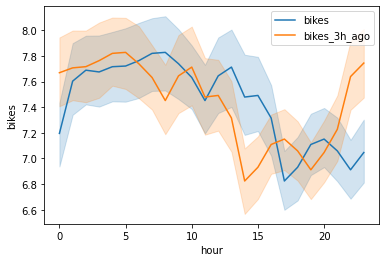

In [ ]:
data_bike = dataset.copy()
data_bike['plot'] = 'bikes'
data_bike2 = dataset.copy()
data_bike2['plot'] = 'bikes_3h_ago'
data_bike['bikes'] = data_bike['bikes_3h_ago']

data_b = data_bike.append(data_bike2)
data_b = data_b.reset_index()

ax = sns.lineplot(data = data_b, x = 'hour', y = 'bikes', hue = 'plot')
#ax = sns.lineplot(data = data_v, x = 'hour', y = 'bikes_3h_ago')
plt.legend()
plt.show()

Tsfresh (https://tsfresh.readthedocs.io/en/latest/text/introduction.html) was the python library used to extrapolate time series featured with the image below describing what some of these features are.

![Getting Started](./data/Images/time_series.png)

Datapoints are collected hourly so the training used 'hour' plots simiar to that shown at the start of the section to generate features. The code below shows the features extracted per station.

In [ ]:
#%% timeseries
from tsfresh.feature_extraction import extract_features, MinimalFCParameters, ComprehensiveFCParameters
settings = MinimalFCParameters()

def label_dist2 (row):
    x = extracted_features
    x = x.iloc[int(row['day'])-1]
    return x

data_ts = pd.DataFrame()

for sta in np.linspace(201,275, 75):
    data_t = datasetb[datasetb['station']==sta]
    data_time = data_t[['day', 'hour', 'bikes_3h_ago']]
    extracted_features = extract_features(data_time, column_id="day", column_sort="hour", default_fc_parameters=settings, n_jobs=0)

    cols = extracted_features.columns.tolist()
    data_t[cols] = data_t.apply (lambda row: label_dist2(row), axis=1)

    if len(data_ts) == 0:
        data_ts = data_t
    else:
        data_ts = data_ts.append(data_t)

data_ts.head(10)

Feature Extraction: 100%|██████████| 31/31 [00:00<00:00, 312.13it/s]
/Users/philippatton/Documents/Data science/MB_2021/MB21env/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
Feature Extraction: 100%|██████████| 31/31 [00:00<00:00, 181.12it/s]
/Users/philippatton/Documents/Data science/MB_2021/MB21env/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
Feature Extr

,station,latitude,longitude,numDocks,timestamp,year,month,day,hour,weekhour,...,bikes_3h_ago__sum_values,bikes_3h_ago__median,bikes_3h_ago__mean,bikes_3h_ago__length,bikes_3h_ago__standard_deviation,bikes_3h_ago__variance,bikes_3h_ago__root_mean_square,bikes_3h_ago__maximum,bikes_3h_ago__absolute_maximum,bikes_3h_ago__minimum
0,201.0,39.478178,-0.383541,27.0,1.412114e+09,2014.0,10.0,1.0,0.0,49.0,...,101.0,3.0,4.208333,24.0,4.499807,20.248264,6.161033,19.0,19.0,0.0
1,201.0,39.478178,-0.383541,27.0,1.412118e+09,2014.0,10.0,1.0,1.0,50.0,...,101.0,3.0,4.208333,24.0,4.499807,20.248264,6.161033,19.0,19.0,0.0
2,201.0,39.478178,-0.383541,27.0,1.412122e+09,2014.0,10.0,1.0,2.0,51.0,...,101.0,3.0,4.208333,24.0,4.499807,20.248264,6.161033,19.0,19.0,0.0
3,201.0,39.478178,-0.383541,27.0,1.412125e+09,2014.0,10.0,1.0,3.0,52.0,...,101.0,3.0,4.208333,24.0,4.499807,20.248264,6.161033,19.0,19.0,0.0
4,201.0,39.478178,-0.383541,27.0,1.412129e+09,2014.0,10.0,1.0,4.0,53.0,...,101.0,3.0,4.208333,24.0,4.499807,20.248264,6.161033,19.0,19.0,0.0
5,201.0,39.478178,-0.383541,27.0,1.412132e+09,2014.0,10.0,1.0,5.0,54.0,...,101.0,3.0,4.208333,24.0,4.499807,20.248264,6.161033,19.0,19.0,0.0
6,201.0,39.478178,-0.383541,27.0,1.412136e+09,2014.0,10.0,1.0,6.0,55.0,...,101.0,3.0,4.208333,24.0,4.499807,20.248264,6.161033,19.0,19.0,0.0
7,201.0,39.478178,-0.383541,27.0,1.412140e+09,2014.0,10.0,1.0,7.0,56.0,...,101.0,3.0,4.208333,24.0,4.499807,20.248264,6.161033,19.0,19.0,0.0
8,201.0,39.478178,-0.383541,27.0,1.412143e+09,2014.0,10.0,1.0,8.0,57.0,...,101.0,3.0,4.208333,24.0,4.499807,20.248264,6.161033,19.0,19.0,0.0
9,201.0,39.478178,-0.383541,27.0,1.412147e+09,2014.0,10.0,1.0,9.0,58.0,...,101.0,3.0,4.208333,24.0,4.499807,20.248264,6.161033,19.0,19.0,0.0


Using a random tree regressor with the extrapolated features on the Phase 1 training set, a Mean Absolute Error of 2.07 was calculated for a cross validation score with 5 folds.

This cross validation score outperformed every other tested algorithm but unfortunately the model could not be used on the Kaggle test set due to sparse level of data. Where the training data had 55875 rows over 1 month, the test set had 2250 rows over 3 months. This resulted in there not being enough datapoints to complete time series feature engineering on the test set and test the models. Therefore it is not possible to fully assess the time series features.

Future work would look into using the Tsfresh rolling methodology to predict short term variations in bikes (https://tsfresh.readthedocs.io/en/latest/text/forecasting.html) rather than feature engineering the test set.